<center>
    
# [Компьютерное зрение](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 5

<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_05/Seminar_5.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

***

In [ ]:
from pathlib import Path

import cv2

import matplotlib.pyplot as plt

import numpy as np

# О датасете

В рамках данного семинара предлагается поработать с изображениями с конкурса по анализу данных Proppant Check Challenge. Описание задачи и данных можно посмотреть на сайте соревнования: https://boosters.pro/championship/RPCC

Ранее можно было скачать весь датасет https://boosters.pro/api/ch/files/pub/RPCC_train.zip, однако по состоянию на 01.02.2023 эта ссылка возвращает 404. Однако для выполнения данного задания весь датасет и не нужен, достаточно будет "чудом уцелевшего" изображения `./data/rpcc_sample.png` (его разрешение ниже, чем в оригинальном датасете, но на общий ход решения это не влияет).

In [ ]:
# !wget https://boosters.pro/api/ch/files/pub/RPCC_train.zip

In [ ]:
IMG_PATH = "data/rpcc_sample.png"
TEMPLATE_PATH = "data/rpcc_template.png"

if not Path(IMG_PATH).exists() or not Path(TEMPLATE_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_05/data .

Cloning into 'cv_course_2023'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 94 (delta 28), reused 80 (delta 15), pack-reused 0
Unpacking objects: 100% (94/94), 16.36 MiB | 8.74 MiB/s, done.


# Работа с изображением

Основным заданием будет создание алгоритма предобработки изображений для решения следующей задачи:

**Входные данные:** фотография листа бумаги с нанесенным шаблоном и рассыпанным пропаннатом

**Выходные данные:** кроп входного изображения, содержащего только область с проппанатом.

In [ ]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Изображения в датасете сняты на камеру мобильного телефона под некоторым углом и с некоторого расстояния:

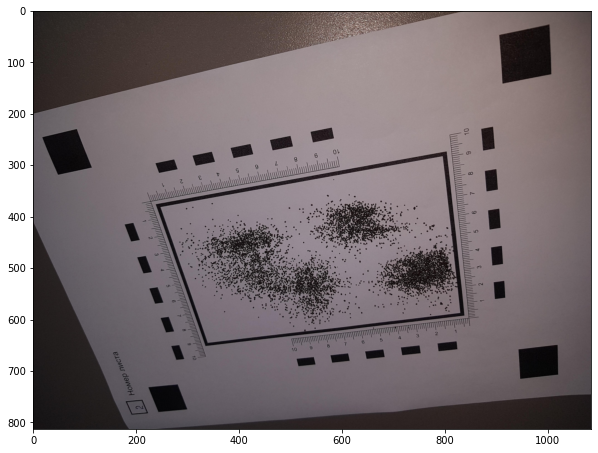

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(img)

На всех фотографиях снят лист бумаги с распечатанным шаблоном и рассыпанным на нем проппанатом. Шаблон извествен:

In [ ]:
template = cv2.imread(TEMPLATE_PATH)

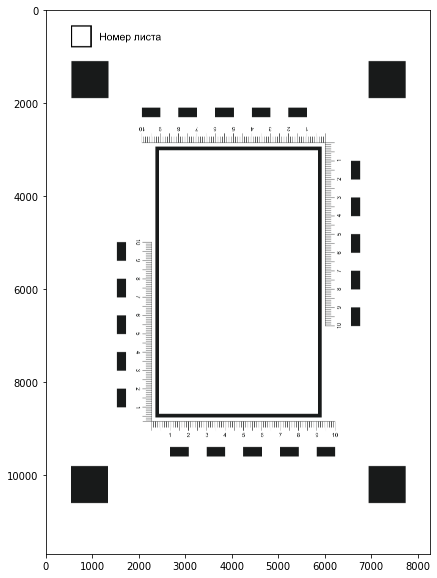

In [ ]:
plt.figure(figsize=[15, 10])
plt.imshow(template)

Далее рассмотрим примеры использования алгоритмов, которые могут быть полезны при решении данной задачи извлечения области с проппанатом.

## Бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Реализация обычной пороговой бинаризации в OpenCV представлена функцией `cv2.threshold` с флагом `cv2.THRESH_BINARY`. Другие флаги, такие как `cv2.THRESH_TRUNC`
`cv2.THRESH_TOZERO` определяют, будут ли изменены значения ниже или выше порога

In [ ]:
ret, th_const = cv2.threshold(
    gray,                   # входное изображение
    128,                    # порог бинаризации
    255,                    # максимальное значения пикселя изображения
    cv2.THRESH_BINARY       # способ бинаризации (cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV)
)

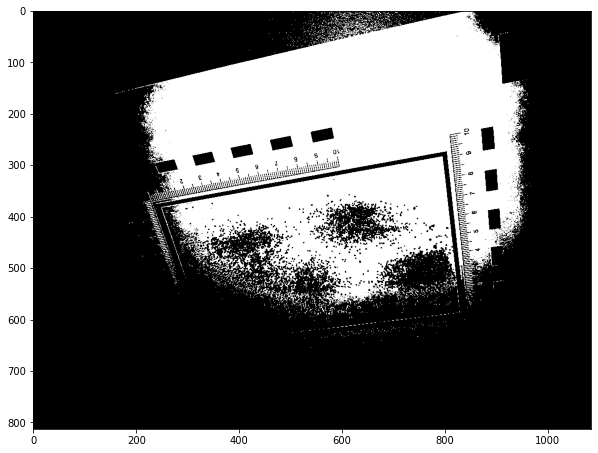

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_const, cmap='Greys_r')

## Вопрос 1

В чем заключается недостаток обычной бинаризации по константному порогу?

**Ответ:** результат получается неудовлетворительный, потому что при даже при таком фиксированном сетапе фотографии из-за разных расстояния фотографии и смене угла разные участки изображения имеют неравномерное распределение уровней интенсивности. Кроме того, это может дать и наклон камеры, естественное освещение или разнообразие оттенков на фотографии, — лучше использовать какой-либо динамический порог или порог, подходящий под конкретное изображение.


Очевидно, что результат неудовлетворителен. Впрочем, можно попробовать подобрать оптимальный порог вручную, основываясь на визуальной оценке качества бинаризации, или осуществить поиск оптимального порога по **методу Отсу**. Делается это передачей дополнительного флага `cv2.THRESH_OTSU`:

In [ ]:
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
print('Оптимальный порог бинаризации по Отсу: ', ret)

Оптимальный порог бинаризации по Отсу:  80.0


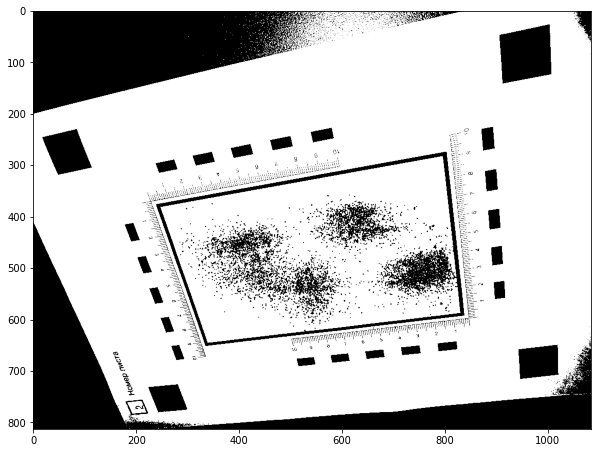

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_otsu, cmap='Greys_r')

Уже значительно лучше. Но попробуем адаптивную бинаризацию

## Адаптивная бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Адаптивная бинаризация в OpenCV представлена методом `cv2.adaptiveThreshold`:

In [ ]:
th_adaptive = cv2.adaptiveThreshold(
    gray,                        # входное изображение
    255,                         # максимальное значения пикселя изображения
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # способ вычисления порога (cv2.ADAPTIVE_THRESH_MEAN_C - среднее, cv.ADAPTIVE_THRESH_GAUSSIAN_C - взвешенное среднее, с весами по гауссиане)
    cv2.THRESH_BINARY,           # способ бинаризации (те же, что и для неадаптивной)
    51,                           # размер окрестности пикселя, рассматриваемой при вычислении порога (должна быть нечетной)
    10                            # это значение вычитается из вычисленного порога, полученная величина - фактический порог бинаризации
)

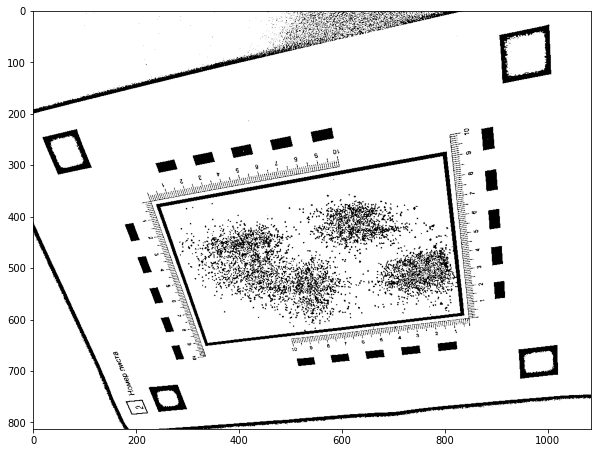

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive, cmap='Greys_r')

Получилось не очень, но, возможно, поможет подбор параметров!

## Вопрос 2

Исходя из результатов работы адаптивной бинаризации, попробуйте определить, какие характеристики исходного изображения могли привести к таким результатам? Другими словами, устойчивость к каким характеристикам входных данных требуется повысить с помощью варьирования параметров или применения дополнительных методов для того, чтобы улучшить результат?

**Ответ:** В первую очередь, это распределение освещённости на изображении: необходимо провести какое-либо гистограммное выравнивание, потому что видно, что среднее, взятое с весами по гауссиане, ведёт себя гораздо лучше. Во-вторых, стоит обратить внимание на то, какого размера окрестность изображения и её зашумлённость, — следовательно, следует обратить внимание на зашумлённость изображения (особенно, тип шума), так как шум влияет на максимальное значение порога бинаризации — хорошо бы очистить изображение от шума всякими крутыми фильтрами на основе свёртки, или варьировать offset бинаризации  + размер окрестнсти (последние 2 аргумента).

## Морфологические преобразования

Туториал: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

Попробуем 'очистить' результаты адаптивной бинаризации, сохранив только ярко выраженные границы. Достигнуть этого можно с помощью морфологического преобразования 'opening' (открытия, раскрытия):

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
th_adaptive_cl = cv2.morphologyEx(th_adaptive, cv2.MORPH_CLOSE, kernel, None, None, 2)
print('Ядро морфологической операции:\n\n', kernel)

Ядро морфологической операции:

 [[0 1 0]
 [1 1 1]
 [0 1 0]]


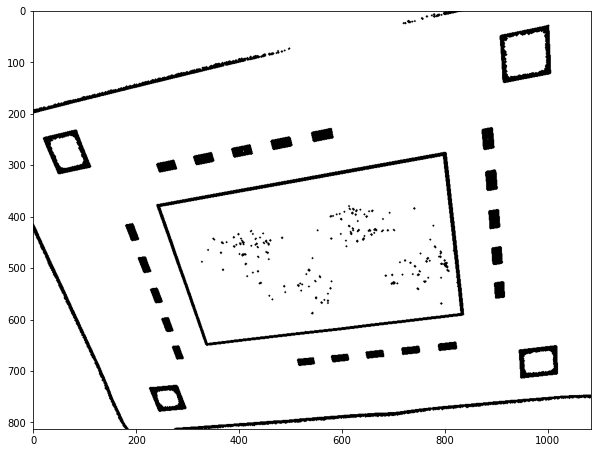

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive_cl, cmap='Greys_r')

## Выделение границ

Туториал: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

Для выделения границ наиболее популярным является метод Канни:

In [ ]:
edges = cv2.Canny(
    th_otsu,    # входное изображение
    100,        # нижний порог гистерезиса
    200,        # верхний порог гистерезиса
    None,       # буфер для ребер, укажем None, так как воспользуемся возвращаемым значением
    3,          # размер ядра дифференциального оператора Собеля
    True        # False/True L1/L2 норма для вичисления отклика по производным
)

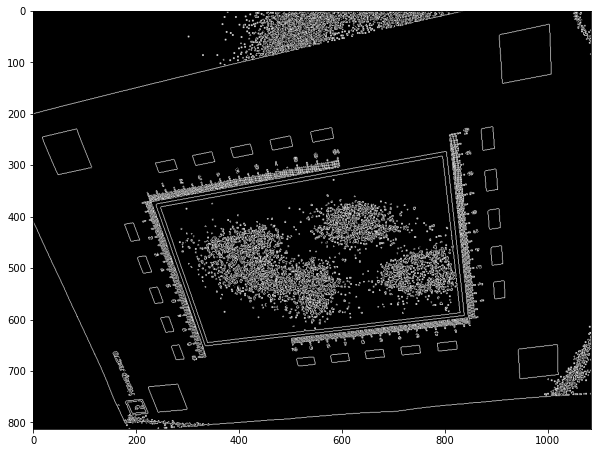

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(edges, cmap='Greys_r')

## Вопрос 3

Для чего применяется процедура гистерезиса в детекторе Канни? Как влияют на результат пороги гистерезиса?

**Ответ:** [Пост](https://habr.com/ru/post/114589/). Это позволяет снизить число разрывов в выходных границах — с одной стороны, повышает устойчивость результатов, а с другой, увеличивает вычислительные затраты и приводит к искажению и даже потере подробностей границ.

Чем меньше порог, тем больше границ будет находиться, но тем более восприимчивым к шуму станет результат, выделяя лишние данные изображения. Наоборот, высокий порог может проигнорировать слабые края или получить границу фрагментами.

## Выделение контуров

Туториал: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Для работы с контурами могут быть полезны следующие средства:

1. `cv2.findContours` - поиск контуров
2. `cv2.contourArea` - площадь фигуры, ограниченной контуром
3. `cv2.arcLength` - длина контура
4. `cv2.isContourConvex` - проверка на выпуклость
5. `cv2.approxPolyDP` - аппроксимация контура более простым (состоящим из меньшего числа звеньев)
6. `cv2.drawContours` - отрисовка контуров

In [ ]:
contours, hierarchy = cv2.findContours(
    th_otsu,                 # входное изображение, бинаризованное
    cv2.RETR_TREE,           # восстановить иерархию контуров по вложенности друг в друга
    cv2.CHAIN_APPROX_NONE    # не аппроксимировать контуры
)

In [ ]:
img_countours = img.copy()
img_countours = cv2.drawContours(img_countours, contours, -1, (255,0,0), 3)
None

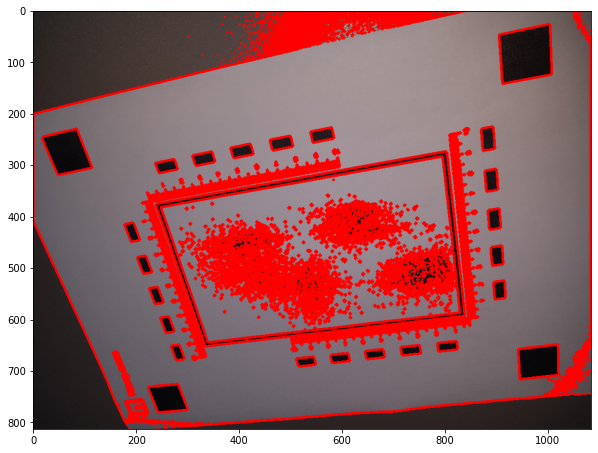

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(img_countours)

## Вопрос 4

На лекции были рассмотрен методы сопоставления с шаблоном (анализ краев, кросс-корреляция). В нашей задаче тоже есть изображение и шаблон. Оцените применимость этих методов в задаче.

**Ответ:** В данной задаче такие методы слабо применимы, потому что перед тем, как как применять методы шаблонов, необходимо произвести выравнивания изображения относительно шаблона — метрики неустойчивы к геометрическим преобразованиям — и правильного выбора сетки для анализа соответствующих изображений, поэтому *если бы задача выравнивая шаблона и исх. изображения* стояла проще, чем задача детекции краёв, то почему бы и нет, но в данном случае, как мне кажется, это не так.

# Задание

Используя средства OpenCV, реазизуйте извлечение области с пропаннатом из изображения.

Примечание: возможно, для выполнения задания дополнительно понадобится применить методы подавления шума и гистограмных преобразаваний, которые были рассмотрены на предыдущих семинарах. Для извлечения прямоугольной области понадобится аппарат проективных преобразований, представленный функциями `cv2.getPerspectiveTransform` - по 4 парам соответствующих точек выдает матрицу гомограции, `cv2.warpPerspective` - применяет преобразование гомографии.

### Пример промежуточных результатов

Сначала выделим границы на изображении. К ним будут отнесены границы поисковых узоров в том числе. Но не только они. Кроме того присутствует шум типа "перец". Его можно удалить, но, как дальше было выяснено, это не влияет на качество выделения линий.

Примечание: это не результат работы детектора Canny

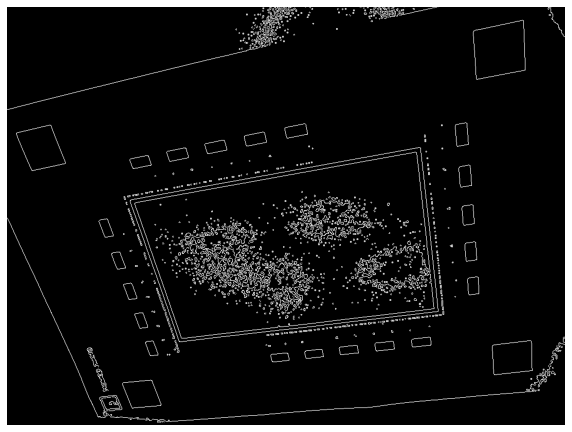

In [ ]:
edges = cv2.Canny(
    cv2.medianBlur(th_otsu, ksize=3),    # входное изображение
    100,        # нижний порог гистерезиса
    200,        # верхний порог гистерезиса
    None,       # буфер для ребер, укажем None, так как воспользуемся возвращаемым значением
    3,          # размер ядра дифференциального оператора Собеля
    True        # False/True L1/L2 норма для вичисления отклика по производным
)
plt.figure(figsize=[10, 10])
plt.imshow(edges, cmap='Greys_r')
plt.axis("off")
plt.show()

Теперь обнаружим прямоугольники, по полученному бинаризованному изображению с границами:

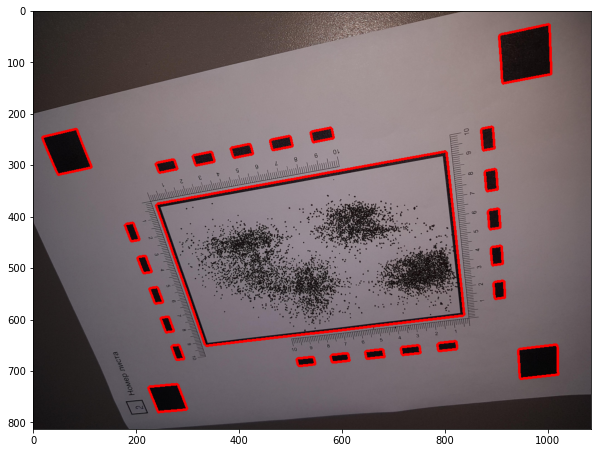

In [ ]:
contours, hierarchy = cv2.findContours(
    edges,          
    cv2.RETR_TREE,           
    cv2.CHAIN_APPROX_NONE    
)
img_countours = img.copy()

#random (empirical, lol)
contours = [c for c in contours if cv2.contourArea(c) > 200]
contours = sorted(contours, key=lambda item: -len(item))[1:]
# frame = contours[2]

img_countours = cv2.drawContours(img_countours, contours, -1, (255,0,0), 3)

plt.figure(figsize=[10, 10])
plt.imshow(img_countours)

Остается выделить целевую область с пропаннатом и произвести выравнивание
<!-- https://theailearner.com/tag/cv2-getperspectivetransform/ -->

In [ ]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect


def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(np.square(br[0] - bl[0]) + np.square(br[1] - bl[1]))
    widthB = np.sqrt(np.square(tr[0] - tl[0]) + np.square(tr[1] - tl[1]))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(np.square(tr[0] - br[0]) + np.square(tr[1] - br[1]))
    heightB = np.sqrt(np.square(tl[0] - bl[0]) + np.square(tl[1] - bl[1]))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth-1, 0],
        [maxWidth-1, maxHeight-1],
        [0, maxHeight-1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

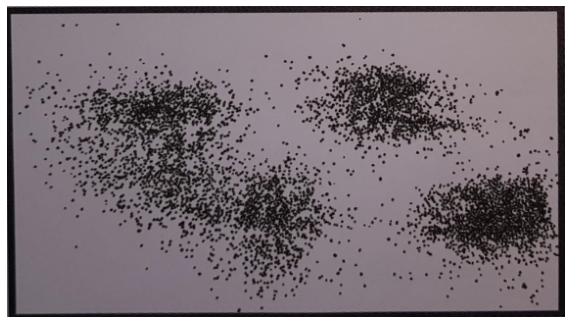

In [ ]:
plt.figure(figsize=[10, 10])
box = np.int0(cv2.approxPolyDP(contours[0], 0.11 * cv2.arcLength(contours[0], True), True))[:, 0]
plt.imshow(four_point_transform(img, box))
plt.axis("off")
plt.show()

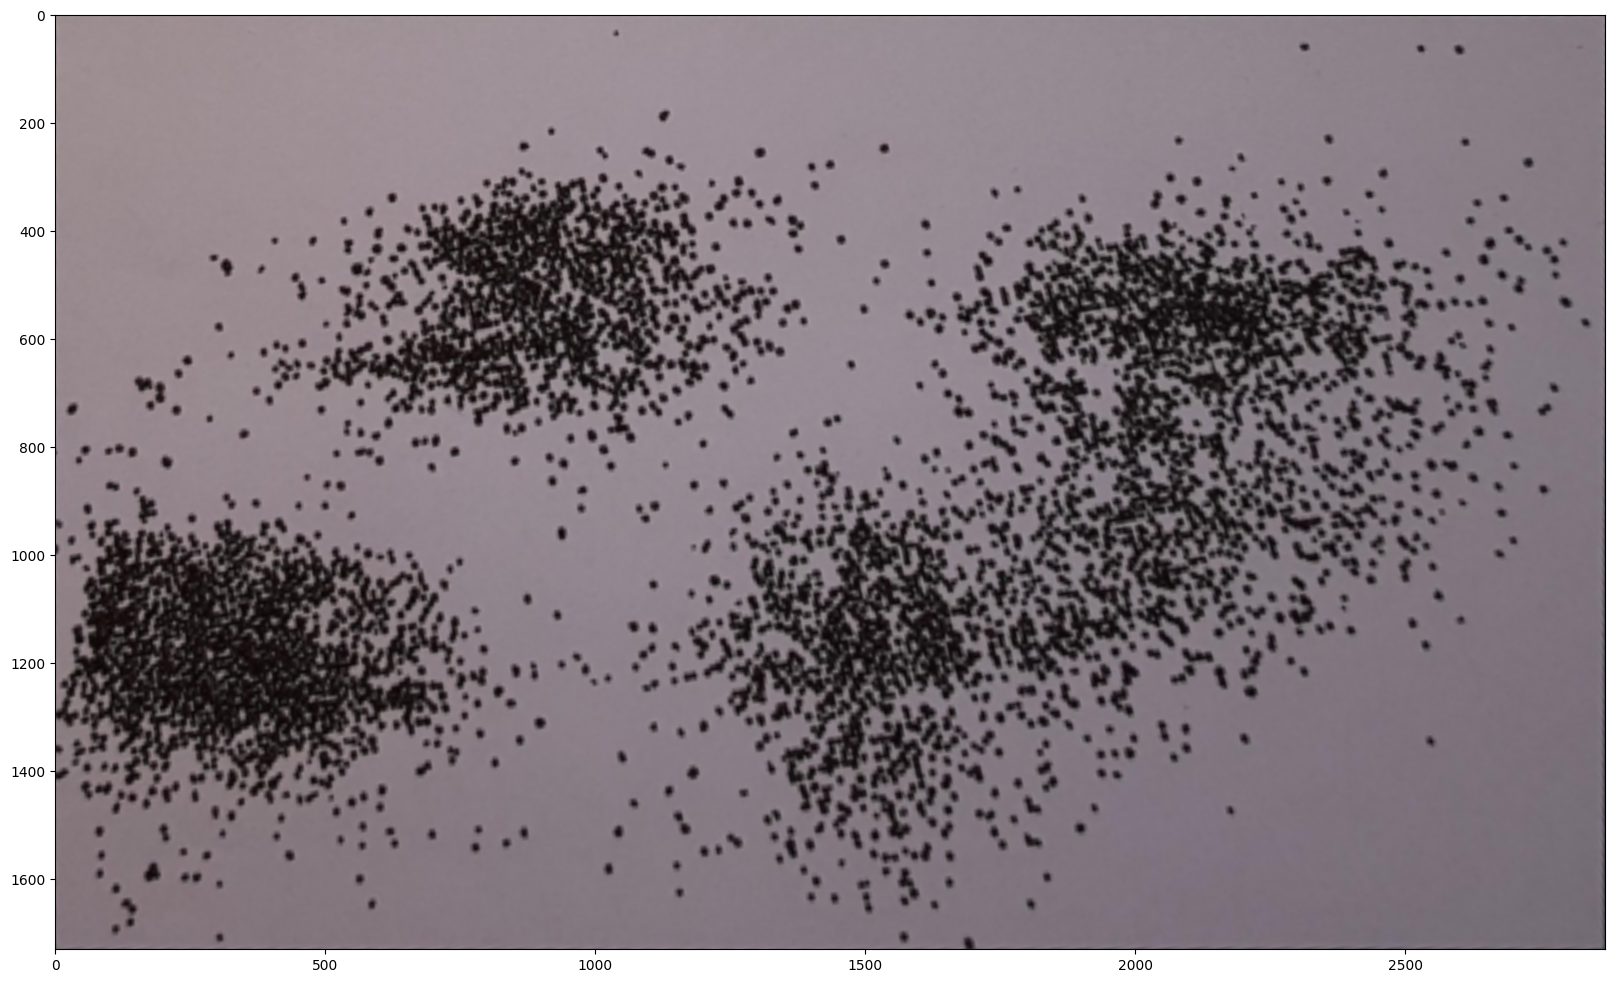

In [ ]:
# здесь был код